In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'
import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


env: THEANO_FLAGS='device=cpu'


In [2]:
%load_ext autoreload
%autoreload 2

# This tutorial explains the basic pipline of Agentnet experiment
* experiment setup
* designing agent
* interacting with environment
* computing losses
* training

# Experiment setup
* Here we load a simple experiment environment (description below)
* Designing one from scratch is explained in later tutorials

In [3]:
import agentnet.experiments.boolean_reasoning as experiment
print(experiment.__doc__)


This is a dummy experiment setup that requires agent to make advantage of
a simple logical formula in order to maximize expected reward.

The world agent exists in has a number of boolean hidden factors:
X1, X2, X3, Y1, Y2.

The factors are not independent. Namely,
 - Y1 is true if X1
 - Y2 is true if not X1

In the initial moment of time, agent knows nothing about any of them.
At each turn, agent may decide to
 - "open" one of the hidden factors.
   - if the factor turns out to be 1, agent receives +1 reward for X*, +3 for Y*
   - Otherwise, the reward equals -1 for X*, -3 for Y*
   - checking a single factor more than once a session will result in -0.5 reward for every attempt but for first one
 - decide to quit session
   - yields reward of 0 and ends the interaction.
   - all farther actions will have no effect until next session

It is expected, that in order to maximize it's expected reward, the agent
will learn the policy
1. Check X1
2. If X1, check Y1, else Y2

The experiment 

In [4]:
#Create an environment with all default parameters
env = experiment.BooleanReasoningEnvironment()

# agent setup
* An agent implementation has to contain three parts:
 * Memory layer(s)
  * in this case, a single one-step RNN
 * Q-values evaluation layers
  * in this case, a lasagne dense layer based on memory layer
 * Resolver - acton picker layer
  * in this case, the resolver has epsilon-greedy policy

In [5]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory.rnn import RNNCell
from agentnet.agent import Agent

In [6]:
import lasagne

#64 hidden neurons
n_hid=64


observation_size = (None,)+tuple(env.observation_shapes)

observation_layer = lasagne.layers.InputLayer(observation_size,name="obs_input")
prev_state_layer = lasagne.layers.InputLayer([None,n_hid],name="prev_state_input")

#memory
#note that this isn't the same as lasagne recurrent units (see next text tab for detail)
rnn = RNNCell(prev_state_layer,
                           observation_layer,
                           name="rnn0")

#q_eval
q_eval = lasagne.layers.DenseLayer(rnn,
                                   num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")

#resolver
epsilon = theano.shared(np.float32(0.1),name="e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")


#all together
agent = Agent(observation_layer,
              {rnn:prev_state_layer},
              q_eval,resolver)


In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[rnn0.hid_to_hid.W,
 rnn0.hid_to_hid.b,
 rnn0.input0_to_hid.W,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* Such sessions are represented as tensors with dimensions matching pattern [batch_session_i, time_tick, ...]
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


In [8]:
#produce interaction sequences of length <= 10
(state_seq,),observation_seq,agent_state,action_seq,qvalues_seq = agent.get_sessions(
    env,
    session_length=10,
    batch_size=env.batch_size,
)


hidden_seq = agent_state[rnn]

#get rewards for all actions
rewards_seq = env.get_reward_sequences(state_seq,action_seq)

#get indicator whether session is still active
is_alive_seq = env.get_whether_alive(observation_seq)


# Evaluating loss function
* In this case, we want to 
 * first get pairs of (predicted Qvalue, reference Qvalue) for all actions commited
 * second, define loss function
 * third, compute grad and update weights

#### Define loss functions

In [9]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning


#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(1),name = 'q_learning_gamma')


squarred_Qerror = qlearning.get_elementwise_objective(
    qvalues_seq,
    action_seq,
    rewards_seq,
    is_alive_seq,
    gamma_or_gammas=gamma,)


mse_Qloss = squarred_Qerror.sum(axis = 1).mean()

In [10]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-3

In [11]:
loss = mse_Qloss + reg_l2

#### Compute weight updates

In [12]:
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.1)

#### Some auxilary evaluation metrics

In [13]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [14]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_Qloss,reg_l2,mean_session_reward])

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '2326' (I am process '2724')
WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


# session visualization tools


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [15]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        hidden_seq,qvalues_seq, action_seq,rewards_seq,is_alive_seq
    ])

def display_sessions(with_plots = False):
        
    hidden_log,qvalues_log,actions_log,reward_log, is_alive_log = get_printables()
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   action_names=env.feature_names,
                  
                  plot_policy = with_plots)

session # 0
 X3(qv = 0.1047108607233243) -> 1.0 |  X3(qv = 0.1487721816656021) -> -0.5 |  X3(qv = 0.11717255847282376) -> -0.5 |  X3(qv = 0.11744179688782036) -> -0.5 |  X3(qv = 0.11899899755002158) -> -0.5 |  X3(qv = 0.1192312077008314) -> -0.5 |  X3(qv = 0.11908735285556071) -> -0.5 |  X3(qv = 0.11907927403699534) -> -0.5 |  Y2(qv = -0.22564962715057713) -> 3.0 |  X1(qv = 0.12676733018666092) -> -1.0 | reached max session length


/root/miniconda/envs/jupyterhub_py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


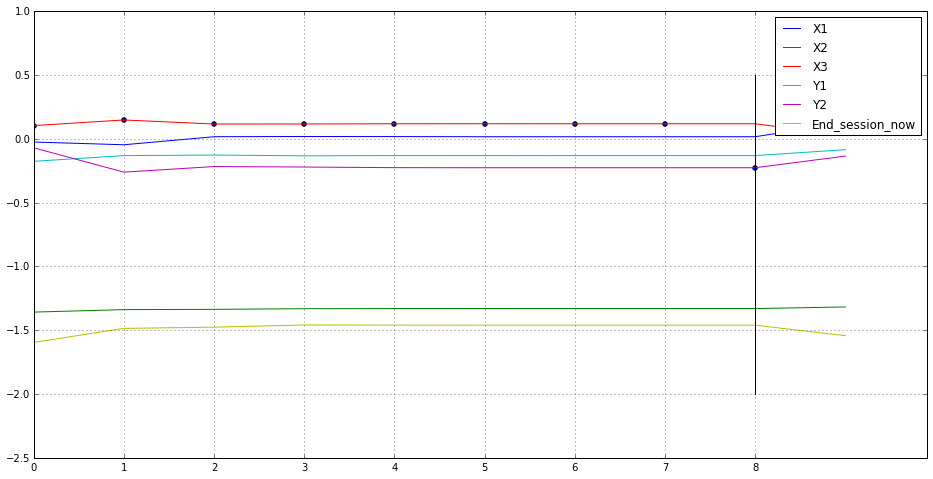

In [16]:
#visualize untrained network performance (which is mostly random)
env.generate_new_data_batch(1)
display_sessions(with_plots=True)

# Training loop

In [17]:
from agentnet.display import Metrics
score_log = Metrics()

In [18]:
#starting epoch
epoch_counter = 1

#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 100,loss 9.16716, epsilon 0.96275, rewards: ( e-greedy -0.11500, greedy -0.02000) 
rec 9.077 reg 0.090
epoch 200,loss 9.87884, epsilon 0.92696, rewards: ( e-greedy -0.24350, greedy 0.00200) 
rec 9.790 reg 0.089
epoch 300,loss 3.52279, epsilon 0.89257, rewards: ( e-greedy -0.19915, greedy 0.02180) 
rec 3.434 reg 0.089
epoch 400,loss 8.63520, epsilon 0.85954, rewards: ( e-greedy -0.24923, greedy 0.07962) 
rec 8.547 reg 0.088
epoch 500,loss 7.94226, epsilon 0.82779, rewards: ( e-greedy -0.20931, greedy -0.39834) 
rec 7.854 reg 0.088
epoch 600,loss 9.66890, epsilon 0.79730, rewards: ( e-greedy -0.23338, greedy -0.68851) 
rec 9.581 reg 0.088
epoch 700,loss 12.22786, epsilon 0.76799, rewards: ( e-greedy -0.11004, greedy -0.63466) 
rec 12.141 reg 0.087
epoch 800,loss 12.28857, epsilon 0.73984, rewards: ( e-greedy -0.20404, greedy -0.79619) 
rec 12.202 reg 0.087
epoch 900,loss 8.15772, epsilon 0.71279, rewards: ( e-greedy -0.19863, greedy -0.94157) 
rec 8.071 reg 0.087
epoch 1000,loss 11

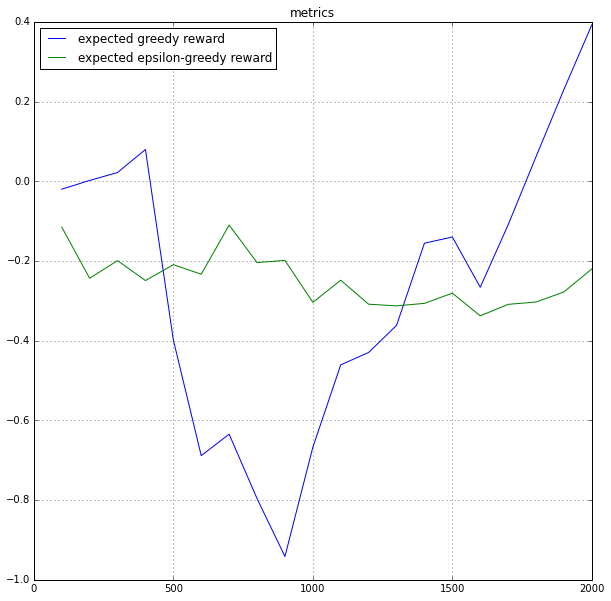

Random session examples
session # 0
 X1(qv = 0.45363969955444805) -> 1.0 |  X2(qv = 0.07997771533128384) -> -1.0 |  Y1(qv = 0.21648425315376277) -> 3.0 |  X3(qv = -0.002163592671664921) -> -1.0 |  End_session_now(qv = -0.02002900326822246) -> 0.0 | 



/root/miniconda/envs/jupyterhub_py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


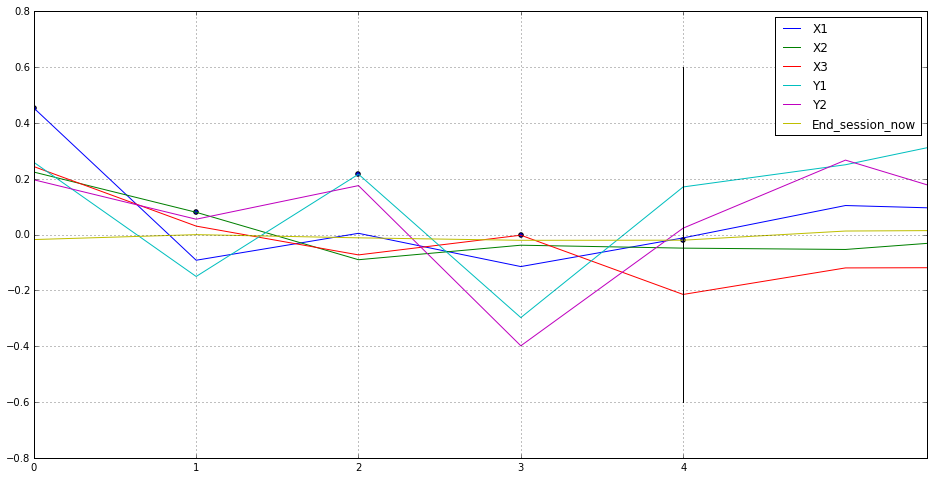

session # 1
 X1(qv = 0.45363969955444805) -> -1.0 |  X2(qv = 0.1143911025622886) -> 1.0 |  End_session_now(qv = 0.004184718597171011) -> 0.0 | 



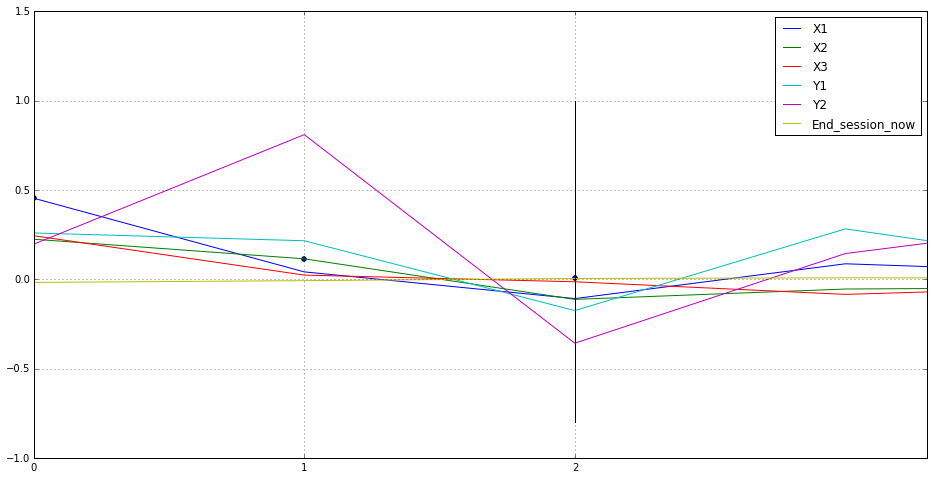

session # 2
 X3(qv = 0.24375631930314584) -> -1.0 |  X2(qv = 0.042464218743177747) -> -1.0 |  Y2(qv = 0.3000148162091926) -> -3.0 |  End_session_now(qv = -0.01372753457210131) -> 0.0 | 



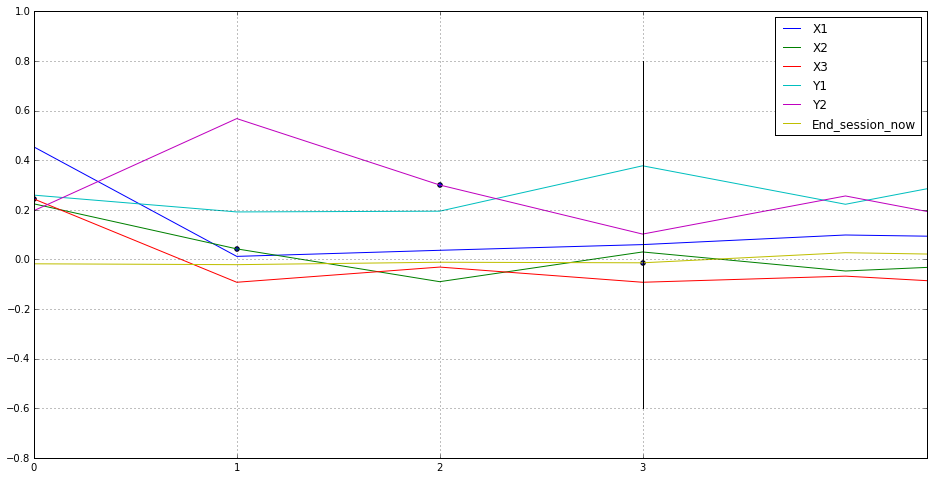

epoch 2100,loss 10.11929, epsilon 0.46012, rewards: ( e-greedy -0.26297, greedy 0.33315) 
rec 10.027 reg 0.092
epoch 2200,loss 8.51192, epsilon 0.44404, rewards: ( e-greedy -0.14667, greedy 0.47483) 
rec 8.419 reg 0.093
epoch 2300,loss 8.50241, epsilon 0.42859, rewards: ( e-greedy -0.09700, greedy 0.41235) 
rec 8.408 reg 0.095
epoch 2400,loss 6.76695, epsilon 0.41375, rewards: ( e-greedy -0.06230, greedy 0.55112) 
rec 6.670 reg 0.097
epoch 2500,loss 7.16695, epsilon 0.39949, rewards: ( e-greedy -0.02107, greedy 0.66600) 
rec 7.068 reg 0.099
epoch 2600,loss 7.69943, epsilon 0.38578, rewards: ( e-greedy -0.11897, greedy 0.45940) 
rec 7.599 reg 0.100
epoch 2700,loss 9.95502, epsilon 0.37262, rewards: ( e-greedy -0.07207, greedy 0.41346) 
rec 9.853 reg 0.102
epoch 2800,loss 7.98852, epsilon 0.35997, rewards: ( e-greedy 0.05014, greedy 0.60712) 
rec 7.884 reg 0.104
epoch 2900,loss 6.28168, epsilon 0.34781, rewards: ( e-greedy 0.08012, greedy 0.65640) 
rec 6.175 reg 0.106
epoch 3000,loss 6.0

In [ ]:
n_epochs = 5000
batch_size=10

for i in range(n_epochs):    
    
    #train
    env.generate_new_data_batch(batch_size)
    loss,avg_reward = train_fun()
    
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%10 ==0:
        current_epsilon =  0.05 + 0.95*np.exp(-epoch_counter/2500.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##show current learning progress
    if epoch_counter%100 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected epsilon-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print("epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy))
        print("rec %.3f reg %.3f"%(q_loss,l2_penalty))

        
    #visualize learning curve and sample sessions
    if epoch_counter %2000 ==0:
        print("Learning curves:")
        score_log.plot()
        
        print("Random session examples")
        env.generate_new_data_batch(3)
        display_sessions(with_plots=True)



        
        
    epoch_counter  +=1


# Evaluate results

In [ ]:
score_log.plot("final")

In [ ]:
resolver.epsilon.set_value(np.float32(0.))
print("Random session examples")
env.generate_new_data_batch(10)
display_sessions(with_plots=True)
